## 4. GMM(Gaussian Mixture Model)

- GMM 군집화는 군집화를 적용하고자 하는 데이터가 여러 개의 가우시안 분포를 가진 데이터 집합들이 섞여서 생성된 것이라는 가정하에 군집화를 수행하는 방식이다.
- 즉 서로 다른 정규 분포 형태를 가진 여러가지 pdf 가 섞여 합쳐서 전체 데이터 세트가 구성되며 이러한 서로 다른 정규분포에 기반해 군집화를 수행하는 것을 의미한다.

- 클러스터링 하려는 데이터 분포에 대해서 여러 개의 정규 분포 곡선을 추출하고, 개별 데이터가 이 중 어떤 정규 분포에 속하는지 결정하는 방식이다. 이를 GMM에서 **모수 추정**이라고 한다. 이는 대표적으로 아래와 같은 2가지를 추정한다.
    - 개별 정규 분포의 평균과 분산
    - 각 데이터가 어떤 정규분포에 해당되는지의 확률
    
- 이를 위해 EM(Expectation and Maximization) 방법을 적용한다. 이 방식을 통한 모수 추정 군집화를 위해 GaussianMixture 클래스 지원

### GMM 을 이용한 붓꽃 데이터 셋 클러스터링

In [1]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']

# 보다 편리한 데이타 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

In [2]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0).fit(iris.data)
gmm_cluster_labels = gmm.predict(iris.data)

# 클러스터링 결과를 irisDF 의 'gmm_cluster' 컬럼명으로 저장
irisDF['gmm_cluster'] = gmm_cluster_labels
irisDF['target'] = iris.target

# target 값에 따라서 gmm_cluster 값이 어떻게 매핑되었는지 확인. 
iris_result = irisDF.groupby(['target'])['gmm_cluster'].value_counts()
print(iris_result)

target  gmm_cluster
0       0              50
1       2              45
        1               5
2       1              50
Name: gmm_cluster, dtype: int64


In [3]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300,random_state=0).fit(iris.data)
kmeans_cluster_labels = kmeans.predict(iris.data)
irisDF['kmeans_cluster'] = kmeans_cluster_labels
iris_result = irisDF.groupby(['target'])['kmeans_cluster'].value_counts()
print(iris_result)

target  kmeans_cluster
0       1                 50
1       0                 48
        2                  2
2       2                 36
        0                 14
Name: kmeans_cluster, dtype: int64


### GMM과 K-평균의 비교
- Kmean은 원형 범위에서 군집화를 수행, 즉 데이터 세트가 원형 범위를 가질수록 군집화 효율 상승!!
- 하지만 데이터가 원형 범위로 퍼져 있지 않은 경우에는 군집화를 잘 수행하지 못한다. 이 경우 GMM이 효과적인 대안이 될 수 있다. (다만 수행시간이 좀 더 오래걸린다.)

In [4]:
### 클러스터 결과를 담은 DataFrame과 사이킷런의 Cluster 객체등을 인자로 받아 클러스터링 결과를 시각화하는 함수  
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()

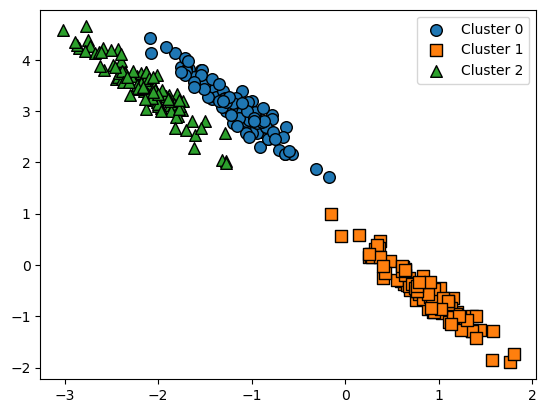

In [5]:
from sklearn.datasets import make_blobs

# make_blobs() 로 300개의 데이터 셋, 3개의 cluster 셋, cluster_std=0.5 을 만듬. 
X, y = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=0.5, random_state=0)

# 길게 늘어난 타원형의 데이터 셋을 생성하기 위해 변환함. 
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
# feature 데이터 셋과 make_blobs( ) 의 y 결과 값을 DataFrame으로 저장
clusterDF = pd.DataFrame(data=X_aniso, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y
# 생성된 데이터 셋을 target 별로 다른 marker 로 표시하여 시각화 함. 
visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

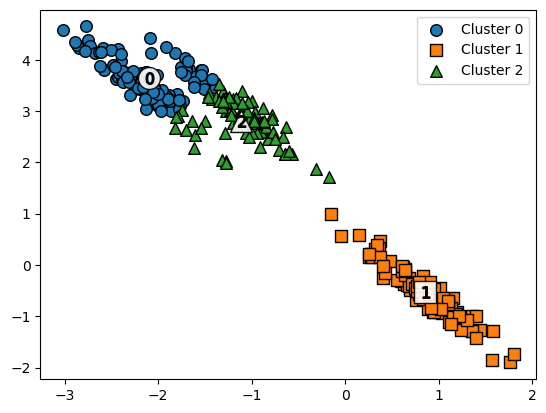

In [6]:
# 3개의 Cluster 기반 Kmeans 를 X_aniso 데이터 셋에 적용 
kmeans = KMeans(3, random_state=0)
kmeans_label = kmeans.fit_predict(X_aniso)
clusterDF['kmeans_label'] = kmeans_label

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_label',iscenter=True)

군집화가 제대로 수행되지 않은 것을 볼 수 있다. (cluster 0, 2에 대해서)

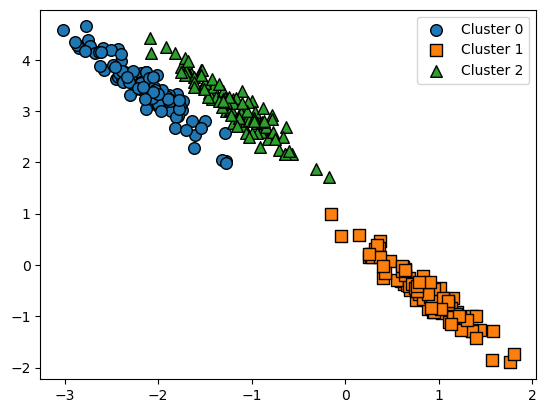

In [7]:
# 3개의 n_components기반 GMM을 X_aniso 데이터 셋에 적용 
gmm = GaussianMixture(n_components=3, random_state=0)
gmm_label = gmm.fit(X_aniso).predict(X_aniso)
clusterDF['gmm_label'] = gmm_label

# GaussianMixture는 cluster_centers_ 속성이 없으므로 iscenter를 False로 설정. 
visualize_cluster_plot(gmm, clusterDF, 'gmm_label',iscenter=False)

In [8]:
print('### KMeans Clustering ###')
print(clusterDF.groupby('target')['kmeans_label'].value_counts())
print('\n### Gaussian Mixture Clustering ###')
print(clusterDF.groupby('target')['gmm_label'].value_counts())

### KMeans Clustering ###
target  kmeans_label
0       2                73
        0                27
1       1               100
2       0                86
        2                14
Name: kmeans_label, dtype: int64

### Gaussian Mixture Clustering ###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: gmm_label, dtype: int64
